# Прогнозирование температуры звезды

## Описание проекта
**Задача от обсерватории «Небо на ладони»**: разработать нейросеть для определения температуры на поверхности обнаруженных звёзд.

### Цель проекта
Создать модель машинного обучения, которая будет предсказывать абсолютную температуру звезды на основе её характеристик.

---

## Традиционные методы расчёта температуры
Обычно учёные используют:
1. **Закон смещения Вина**
2. **Закон Стефана-Больцмана** 
3. **Спектральный анализ**

Каждый метод имеет преимущества и недостатки. ML-подход должен стать более точной и удобной альтернативой.

---

## Данные для обучения
В базе обсерватории есть характеристики **240 изученных звёзд**:

### Признаки звезды:
| Признак | Описание |
|---------|-----------|
| **Относительная светимость** | L/Lo - светимость звезды относительно Солнца |
| **Относительный радиус** | R/Ro - радиус звезды относительно радиуса Солнца |
| **Абсолютная звёздная величина** | Mv - физическая величина, характеризующая блеск звезды |
| **Звёздный цвет** | white, red, blue, yellow, yellow-orange и др. |
| **Тип звезды** | Категориальный признак |

### Типы звезд:
| Тип звезды | Числовой код |
|------------|--------------|
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |

### Целевая переменная:
- **Абсолютная температура T(K)** - температура на поверхности звезды в Кельвинах

# Импортируем библиотеки

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import HTML, display
import seaborn as sns
import re
import warnings
import logging
import torch
import torch.nn as nn

# === Библиотеки ML ===
from sklearn.model_selection import train_test_split
import torch.optim as optim

# === Sklearn ===
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer,
)

# === Функции проекта ===
from func import (
    EarlyStoppingCallback,
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
)

# === Настройки ===
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="sklearn.feature_selection._univariate_selection",
)
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

logging.getLogger("sklearn").setLevel(logging.ERROR)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)

# Константы

In [158]:
# зафиксируем константы
RANDOM_STATE = 20
TEST_SIZE = 0.25
N_JOBS = -1
N_ITER = 10 # число итераций для перебора и поиска лучших параметров
N_CROSS_VALL = 3

# Загрузка данных

In [159]:
df = pd.read_csv("../data/6_class.csv")

# Анализ и предобработка данных

In [160]:
df = check_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unnamed:_0               240 non-null    int64  
 1   temperature_(_k)         240 non-null    int64  
 2   luminosity(_l/_lo)       240 non-null    float64
 3   radius(_r/_ro)           240 non-null    float64
 4   absolute_magnitude(_mv)  240 non-null    float64
 5   star_type                240 non-null    int64  
 6   star_color               240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


None

,unnamed:_0,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
212,212,13089,788.000000,5.9920,-0.120,3,blue-white
42,42,3270,150000.000000,88.0000,-6.020,4,red
229,229,21738,748890.000000,92.0000,-7.346,4,blue
141,141,21020,0.001500,0.0112,11.520,2,blue
185,185,2889,0.000352,0.0973,16.930,0,red


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
temperature_(_k),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
luminosity(_l/_lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
radius(_r/_ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
absolute_magnitude(_mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
star_type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


In [161]:
# опять непонятный unnamed:_0 который дублирует индекс
df = df.drop(columns=['unnamed:_0'])

Пропусков нет, но есть цвет звезды - проверим

In [162]:
df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

Так и оказалось, заполняли непонятно как... приведем неявные дубликаты к общему виду и немного наведем красоты

In [163]:
# PS: как именно обозначал автор цвета звезд, не совсем понятно.
# Возьмем первое слово = преобладающий цвет
color_mapping = {
    'blue': 'blue',
    'blue white': 'blue', 
    'blue-white': 'blue',
    
    'white': 'white',
    'whitish': 'white',
    'white-yellow': 'white',
    
    'yellow-white': 'yellow',
    'yellowish': 'yellow',
    'yellowish white': 'yellow',
    'pale yellow orange': 'yellow',
    
    'orange': 'orange',
    'orange-red': 'red',
    
    'red': 'red'
}

df['star_color'] = df['star_color'].str.strip().str.lower().replace(color_mapping)
df['star_color'].unique()

array(['red', 'blue', 'white', 'yellow', 'orange'], dtype=object)

In [164]:
df.sample(5)

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
187,3484,0.000551,0.0998,16.67,0,red
70,3345,0.021000,0.2730,12.30,1,red
54,3650,310000.000000,1324.0000,-7.79,5,red
203,13340,0.001090,0.0116,12.90,2,blue
40,3826,200000.000000,19.0000,-6.93,4,red


Да, цвет звезды не совсем бьется с ее "цветовым типом", но в целом все логично.

In [165]:
# и теперь проверим явные дубликаты после корректировок
df = drop_duplicated(df)

np.int64(0)

'Дубликаты отсутствуют'

Посмотрим на распределение

2025-11-10 23:30:22 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-10 23:30:22 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


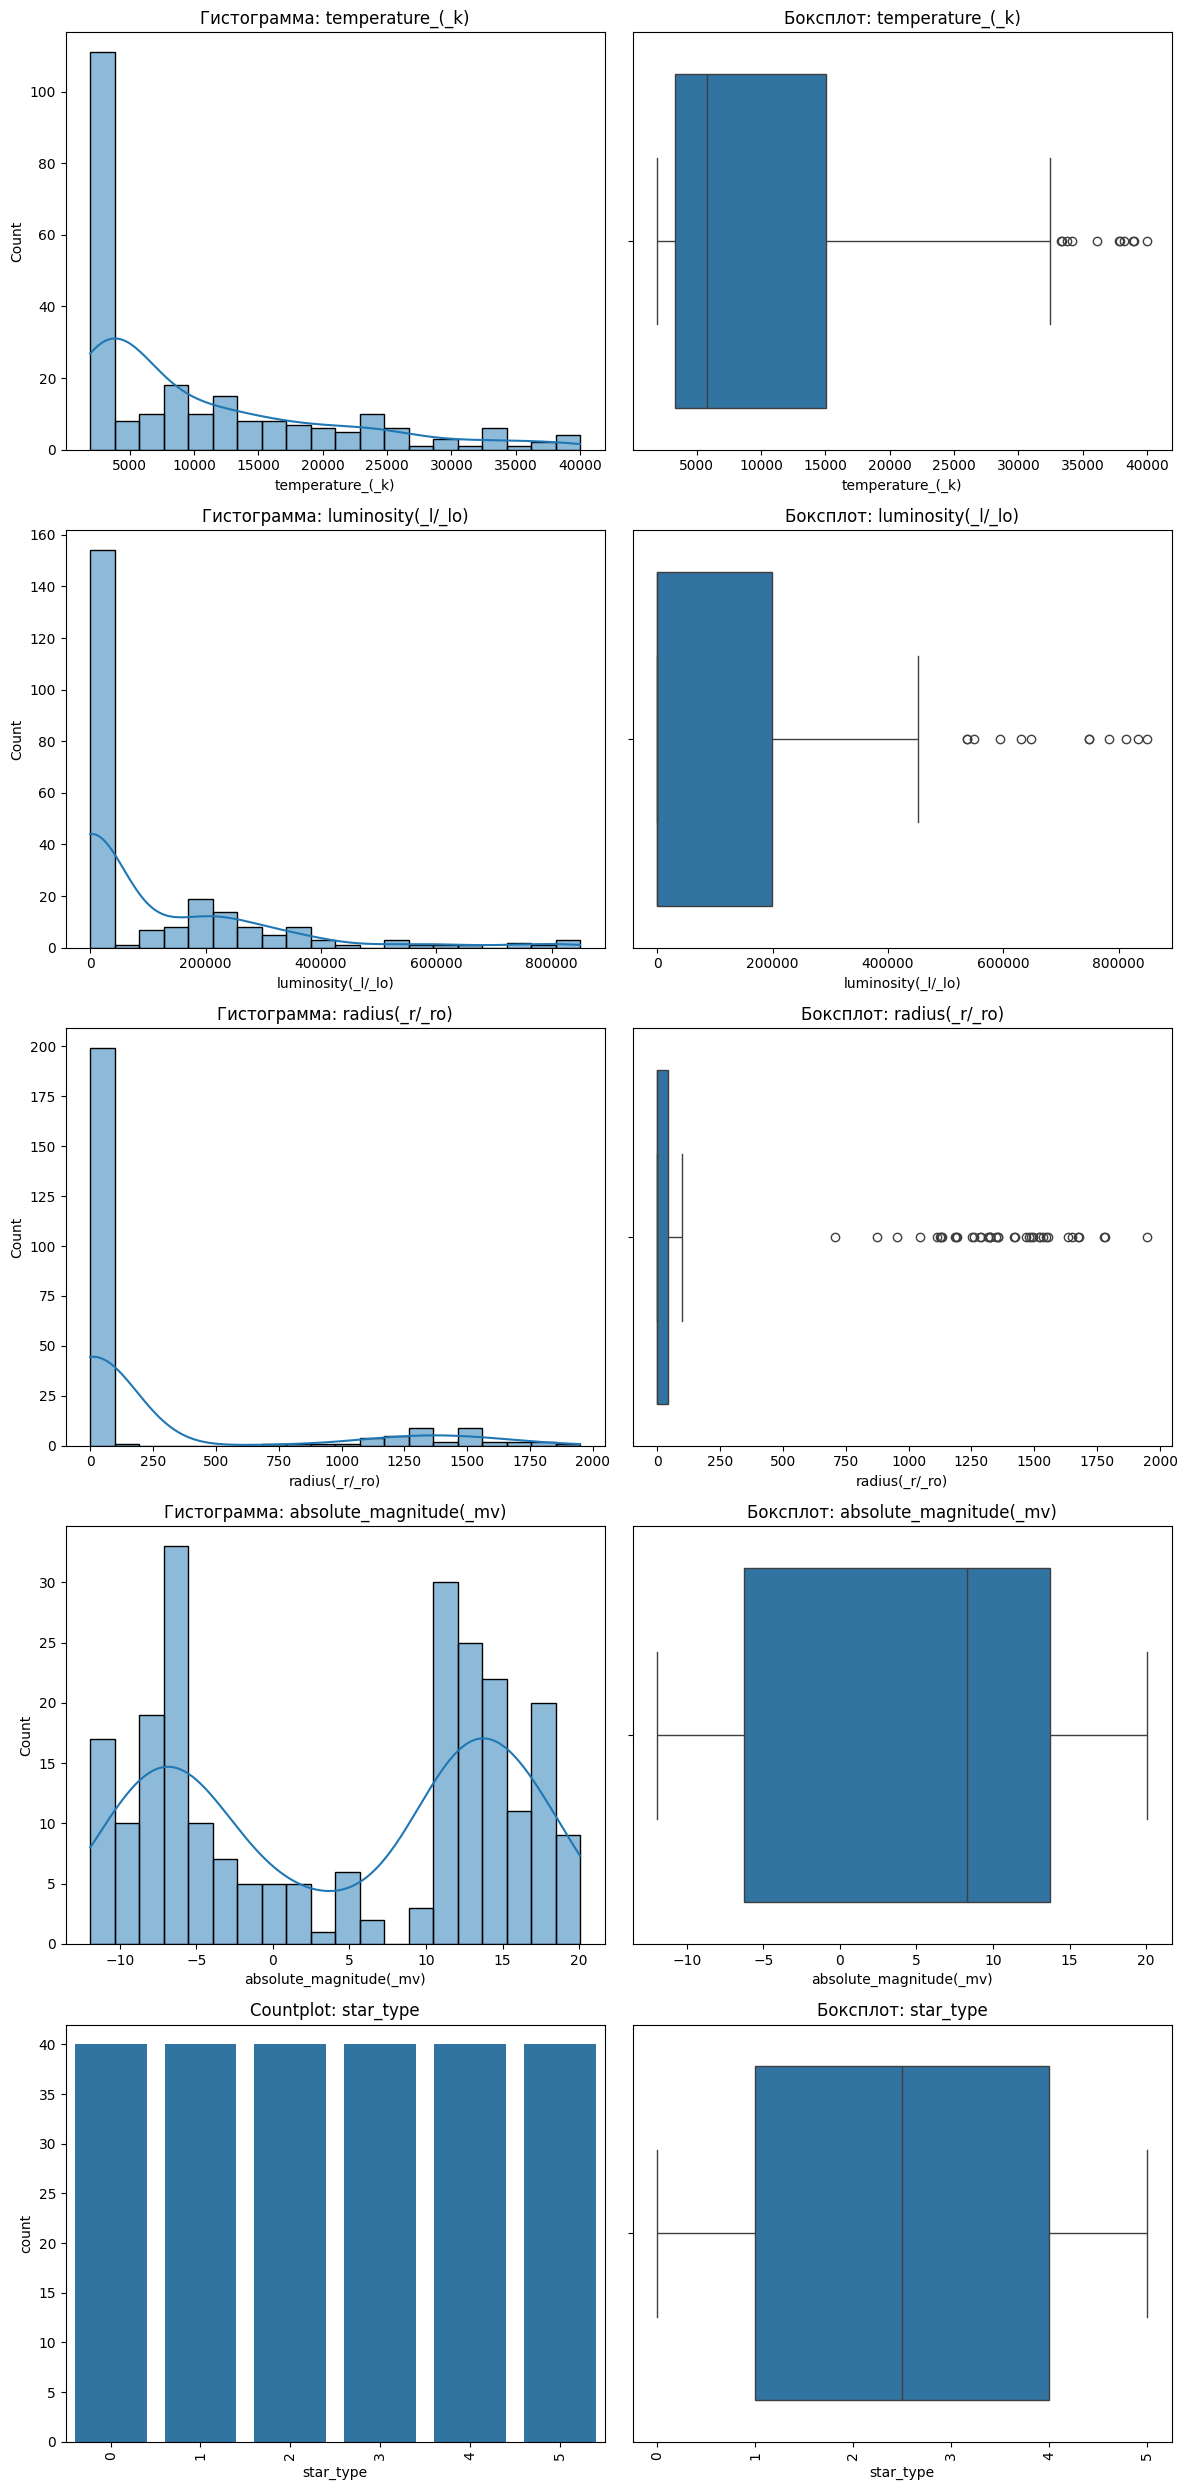

In [166]:
plot_combined(df, col=None, target=None, col_type=None, legend_loc='best')

Распределение по цвету звёзд получилось идеальным, значит теории о том, что первое слово важнее второго, подтверждается. :)  
А вот остальные признаки требуют дополнительного изучения и, наверное, обработки.

In [167]:
# очень много данных temperature_(_k) меньше 5000, посмотрим на них отдельно
df_low_temp = df[df['temperature_(_k)'] < 2000]
df_low_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
4,1939,0.000138,0.103,20.06,0,red


Нулевых нет и на том спасибо.  
К томуже справочный материал говорит, что такая температура вполне возможна.

In [168]:
# и выбросы по высокой температуре
df_high_temp = df[df['temperature_(_k)'] > 35000]
df_high_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
30,39000,204000.0,10.60,-4.70,3,blue
99,36108,198000.0,10.20,-4.40,3,blue
101,40000,813000.0,14.00,-6.23,4,blue
159,37800,202900.0,6.86,-4.56,3,blue
231,38234,272830.0,1356.00,-9.29,5,blue
235,38940,374830.0,1356.00,-9.93,5,blue
239,37882,294903.0,1783.00,-7.80,5,blue


Вопросики по светимости к типу 4 да и в целом все еще непонятно определение цвета звезд.  
Разные типы, разные размеры, разные светимости....  
Ничего непонятно, но очень интересно :)

Теперь свечение luminosity(_l/_lo)

In [169]:
df_low_lum = df[df['luminosity(_l/_lo)'] < 100]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.17000,16.120,0,red
1,3042,0.000500,0.15420,16.600,0,red
2,2600,0.000300,0.10200,18.700,0,red
3,2800,0.000200,0.16000,16.650,0,red
4,1939,0.000138,0.10300,20.060,0,red
...,...,...,...,...,...,...
207,23092,0.001320,0.01040,10.180,2,blue
208,17920,0.001110,0.01060,11.660,2,blue
209,19360,0.001250,0.00998,11.620,2,blue
216,9320,29.000000,1.91000,1.236,3,blue


In [170]:
df_low_lum = df[df['luminosity(_l/_lo)'] > 500000]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
53,3749,550000.0,1648.0,-8.050,5,orange
101,40000,813000.0,14.0,-6.230,4,blue
172,4287,630000.0,1315.0,-9.200,5,orange
223,23440,537430.0,81.0,-5.975,4,blue
226,9892,593900.0,80.0,-7.262,4,blue
227,10930,783930.0,25.0,-6.224,4,blue
229,21738,748890.0,92.0,-7.346,4,blue
232,32489,648430.0,1948.5,-10.840,5,blue
233,27739,849420.0,1252.0,-7.590,5,blue
234,21904,748490.0,1130.0,-7.670,5,blue


Вот о чем и писал выше - светимость огромная, а температура может быть не очень высокой.

Так как у нас идет сравнение с Солнцем, что оставим как есть.  

Радиус radius(_r/_ro) скорее всего покажет схожую картину, но посмотрим.

In [171]:
df_low_rad = df[df['radius(_r/_ro)'] < 100]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.1700,16.120,0,red
1,3042,0.000500,0.1542,16.600,0,red
2,2600,0.000300,0.1020,18.700,0,red
3,2800,0.000200,0.1600,16.650,0,red
4,1939,0.000138,0.1030,20.060,0,red
...,...,...,...,...,...,...
225,18734,224780.000000,46.0000,-7.450,4,blue
226,9892,593900.000000,80.0000,-7.262,4,blue
227,10930,783930.000000,25.0000,-6.224,4,blue
228,23095,347820.000000,86.0000,-5.905,4,blue


In [172]:
df_low_rad = df[df['radius(_r/_ro)'] > 200]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,red
51,3750,283000.0,1260.0,-7.63,5,red
52,3834,272000.0,1183.0,-9.20,5,red
53,3749,550000.0,1648.0,-8.05,5,orange
54,3650,310000.0,1324.0,-7.79,5,red
55,3450,263000.0,1349.0,-11.75,5,red
56,3660,363000.0,1673.0,-11.92,5,red
57,3450,174000.0,1284.0,-11.28,5,red
58,3752,209000.0,955.0,-11.24,5,red
59,3535,195000.0,1546.0,-11.36,5,red


'=== Корреляция с таргетом ==='

star_color                -0.669746
absolute_magnitude(_mv)   -0.420261
star_type                  0.411129
luminosity(_l/_lo)         0.393404
radius(_r/_ro)             0.064216
Name: temperature_(_k), dtype: float64

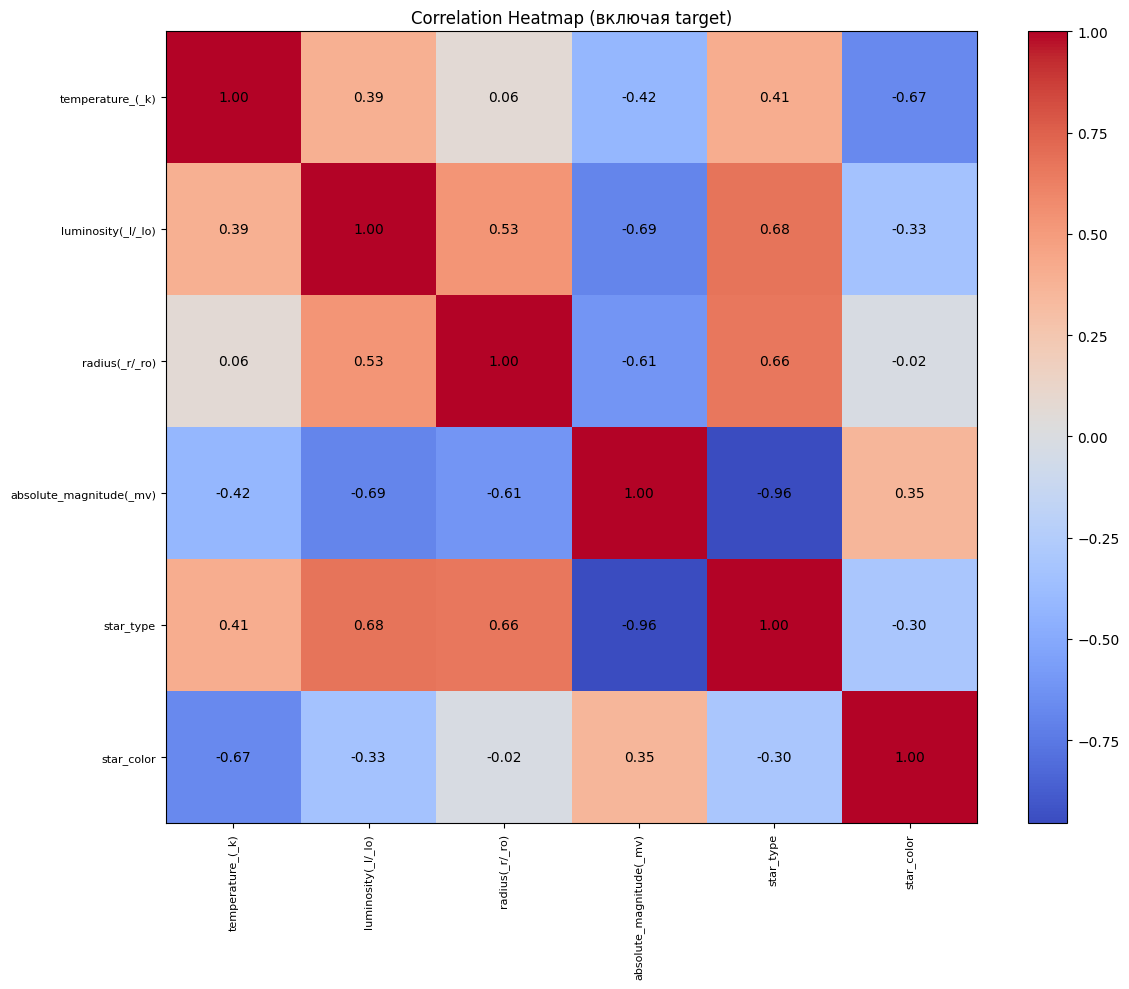

'=== VIF ==='

,feature,VIF
2,absolute_magnitude(_mv),9.108270
3,star_type,5.890457
0,luminosity(_l/_lo),2.694309
1,radius(_r/_ro),2.028803
4,star_color,1.535247


In [173]:
calc_target_correlations(df, target_col="temperature_(_k)")

Мультиколлинеарности не наблюдается.  
VIF в пределах допустимого.

## Выводы по анализу данных

**Основные проблемы в данных о звездах**  

*Несоответствие температуры и цвета*  
-- Холодные звезды указаны с цветами, характерными для горячих звезд  
-- Нарушена физическая связь между температурой и спектральным классом  

*Нарушение астрофизических законов*  
-- Не соблюдается закон Стефана-Больцмана (связь светимости с радиусом и температурой)  
-- Параметры светимости и радиуса противоречат друг другу  

*Статистические аномалии*  
-- Слишком много редких типов звезд (гипергигантов)  
-- Нарушены реальные пропорции встречаемости разных классов звезд  

*Проблемы с классификацией*  
-- Цвета звезд не соответствуют их физическим параметрам  
-- Отсутствует системный подход к классификации по спектральным классам  
-- Произвольное сочетание характеристик без физического обоснования  

*Методологические проблемы*  
-- Данные выглядят сгенерированными, а не наблюдаемыми  
-- Отсутствует внутренняя согласованность параметров  
-- Нарушены известные астрофизические зависимости  

В целом: Данные требуют серьезной доработки для соответствия реальным астрономическим закономерностям.  
Но ввиду того, что это учебный проект, будем работать с тем, что есть.  

# Построение базовой нейронной сети

## Разделение данных на признаки и целевой признак

In [174]:
# разделим на выборки их оставшихся данных
target = 'temperature_(_k)'
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target], axis=1),
    df[target],
    shuffle=True,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [175]:
# разделяем признаки с учетом ordinal переменной
def custom_selector(X):
    """Для разделения признаков"""
    cat_cols = []
    ord_cols = ['star_type']  # явно указываем ordinal признаки
    num_cols = []
    
    for col in X.columns:
        if col in ord_cols:
            continue
        elif X[col].dtype in ['object', 'category']:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    
    return num_cols, cat_cols, ord_cols

num_cols, cat_cols, ord_cols = custom_selector(X_train)

display("Числовые:", num_cols)
display("Категориальные (nominal):", cat_cols)
display("Порядковые (ordinal):", ord_cols)

'Числовые:'

['luminosity(_l/_lo)', 'radius(_r/_ro)', 'absolute_magnitude(_mv)']

'Категориальные (nominal):'

['star_color']

'Порядковые (ordinal):'

['star_type']

In [176]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("to_str", FunctionTransformer(lambda x: x.astype(str))),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_cols),
        ("ord", Pipeline([
            ("scaler", StandardScaler())
        ]), ord_cols)
    ]
)

In [177]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # или ваша модель
])

# Обучаем на тренировочных данных
pipeline.fit(X_train, y_train)

# Получаем преобразованные данные для PyTorch
X_train_processed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)

# Конвертируем в тензоры
X_train_tensor = torch.FloatTensor(X_train_processed)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

# Построение простой модели нейронной сети — baseline

## Создаем класс для задания архитектуры нейронной сети

In [178]:
class StarTemperatureNet(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32, 16], dropout_rate=0.2):
        super(StarTemperatureNet, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Динамически создаем скрытые слои
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Выходной слой (регрессия - один нейрон)
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [179]:
# Функция для обучения
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.001, patience=50):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)
    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Обучение
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        train_loss = criterion(predictions, y_train.unsqueeze(1))
        train_loss.backward()
        optimizer.step()
        
        # Валидация
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test)
            test_loss = criterion(test_predictions, y_test.unsqueeze(1))
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        
        # Early stopping
        if test_loss.item() < best_loss:
            best_loss = test_loss.item()
            patience_counter = 0
            # Сохраняем лучшие веса
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            logger.info(f'Early stopping at epoch {epoch}')
            break
        
        # Обновление learning rate
        scheduler.step(test_loss)
        
        if epoch % 100 == 0:
            logger.info(f'Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    # Загружаем лучшие веса
    model.load_state_dict(torch.load('best_model.pth'))
    
    return train_losses, test_losses

In [182]:
# Функция для построения графиков
def plot_results(model, X_test, y_test, train_losses, test_losses):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    
    # Конвертируем в numpy для визуализации
    y_test_np = y_test.numpy()
    predictions_np = predictions.squeeze().numpy()
    
    # Создаем subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График 1: Факт vs Прогноз (столбиками)
    num_stars = len(y_test_np)
    bar_width = 0.4
    x_pos = np.arange(num_stars)
    
    # Внутренний столбик - Факт (синий)
    bars_fact = ax1.bar(x_pos - bar_width/2, y_test_np, bar_width, 
                       label='Факт', color='blue', alpha=0.8, edgecolor='black')
    
    # Внешний столбик - Прогноз (желтый, прозрачный 50%)
    bars_pred = ax1.bar(x_pos + bar_width/2, predictions_np, bar_width, 
                       label='Прогноз', color='yellow', alpha=0.5, edgecolor='black')
    
    ax1.set_xlabel('Условные номера звёзд')
    ax1.set_ylabel('Температура (K)')
    ax1.set_title('Факт vs Прогноз температуры звезд')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Потери
    ax2.plot(train_losses, label='Train Loss')
    ax2.plot(test_losses, label='Test Loss')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Loss (MSE)')
    ax2.set_title('График потерь при обучении')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Метрики
    mae = mean_absolute_error(y_test_np, predictions_np)
    r2 = r2_score(y_test_np, predictions_np)
    
    logger.info(f"MAE: {mae:.2f} K")
    logger.info(f"R² Score: {r2:.4f}")
    logger.info(f"Средняя температура: {y_test_np.mean():.2f} K")
    logger.info(f"Std температура: {y_test_np.std():.2f} K")
    
    return mae, r2

2025-11-10 23:33:47 [INFO] __main__: Размер входных данных: 7
2025-11-10 23:33:47 [INFO] __main__: StarTemperatureNet(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)
2025-11-10 23:33:47 [INFO] __main__: Всего параметров: 11393
2025-11-10 23:33:47 [INFO] __main__: Начинаем обучение...
2025-11-10 23:33:47 [INFO] __main__: Epoch 0, Train Loss: 203363040.0000, Test Loss: 194179744.0000
2025-11-10 23:33:47 [INFO] __main__: Epoch 100, Train Loss: 198968256.0000, Test Loss: 189067584.0000
2025-11-10 23:33:47 [INFO] __main__: Epoch 200, Train Loss: 127964728.0000, Test Loss: 112122208.0000
2025-11-10 23:33:48 [I

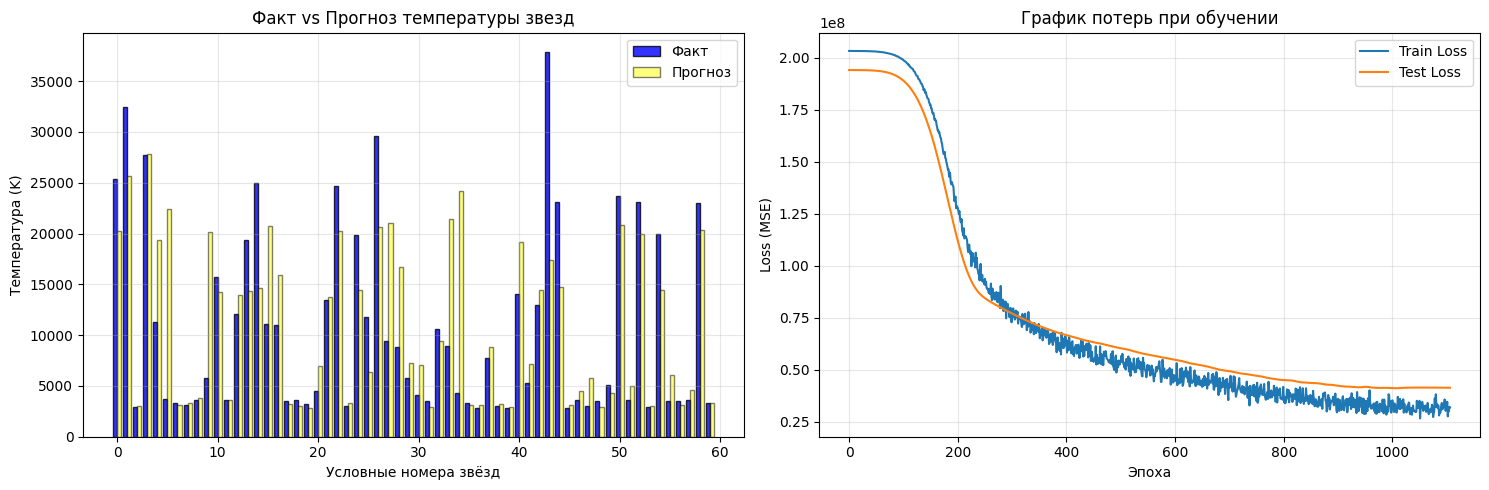

2025-11-10 23:33:50 [INFO] __main__: MAE: 3966.08 K
2025-11-10 23:33:50 [INFO] __main__: R² Score: 0.5065
2025-11-10 23:33:50 [INFO] __main__: Средняя температура: 10519.20 K
2025-11-10 23:33:50 [INFO] __main__: Std температура: 9139.18 K


In [185]:
# Определяем размер входных данных
input_size = X_train_tensor.shape[1]
logger.info(f"Размер входных данных: {input_size}")

# Создаем модель
model = StarTemperatureNet(input_size=input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.2)
logger.info(model)

# Проверяем количество параметров
total_params = sum(p.numel() for p in model.parameters())
logger.info(f"Всего параметров: {total_params}")

# Обучение модели
logger.info("Начинаем обучение...")
train_losses, test_losses = train_model(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    X_test_tensor, 
    y_test_tensor,
    epochs=2000,
    lr=0.001,
    patience=100
)

# Визуализация результатов
mae, r2 = plot_results(model, X_test_tensor, y_test_tensor, train_losses, test_losses)

# Улучшение нейронной сети

# Выводы